In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from tqdm.notebook import tqdm

In [4]:
from run_everything import run_hf, run_pyhf
import pyhf
import scipy.stats
import math
from scipy.stats import norm

Welcome to JupyROOT 6.20/06


In [5]:
data = {
    "binning": [1, 0.5, 1.5],
    "bindata": {"data": [80.0], "bkg": [50.0], "bkgerr": [7.0], "sig": [25.0]},
}

In [6]:
ndata_range = list(range(40, 200, 5))

In [ ]:
hf_pvals = []
for ndata in tqdm(ndata_range):
    hf_pvals.append(run_hf(dict(data, bindata=dict(data["bindata"], data=[ndata]))))

In [8]:
pyhf_pvals = []
for ndata in tqdm(ndata_range):
    pyhf_pvals.append(run_pyhf(dict(data, bindata=dict(data["bindata"], data=[ndata]))))

In [9]:
def get_p0_obs_asymptotic_exact(data):
    # http://www.pp.rhul.ac.uk/~cowan/stat/medsig/medsigNote.pdf
    bd = data["bindata"]
    b = bd["bkg"][0]
    tau = b / (bd["bkgerr"][0] ** 2)
    m = tau * b
    n = bd["data"][0]
    if n <= b:
        return 0.5
    return scipy.stats.norm.sf(
        np.sqrt(-2 * (n * np.log((n + m) / ((1 + tau) * n)) + m * np.log((tau * (n + m)) / ((1 + tau) * m))))
    )

In [10]:
get_p0_obs_asymptotic_exact(data)

0.003936878440204013

In [11]:
obs_exact = [
    get_p0_obs_asymptotic_exact(dict(data, bindata=dict(data["bindata"], data=[ndata])))
    for ndata in ndata_range
]

In [29]:
def ratio(x, a1, a2, title="pvalue", label1="ROOT/Histfactory", label2="pyhf"):
    fig, axs = plt.subplots(nrows=2, figsize=(5, 5))
    axs[0].plot(x, a1, label=label1)
    axs[0].plot(x, a2, label=label2)
    axs[1].plot(x, a1 / a2)
    axs[1].set_xlim(*axs[0].get_xlim())
    axs[0].legend()
    axs[0].set_ylabel(title)
    axs[1].set_ylabel("Ratio")
    return fig, axs

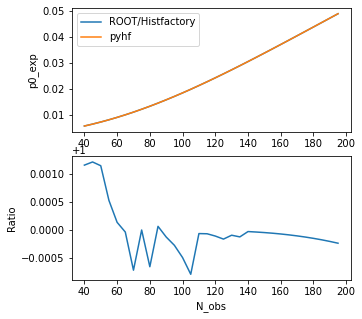

In [30]:
fig, axs = ratio(
    ndata_range,
    np.array([p["p0_exp"][2] for p in hf_pvals]),
    np.array([p["p0_exp"][2] for p in pyhf_pvals]),
    title="p0_exp"
)
axs[1].set_xlabel("N_obs")
plt.show()

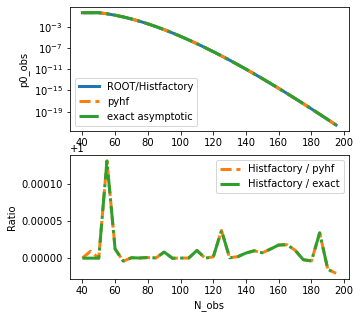

In [28]:
def plot():
    hf = np.array([p["p0_obs"] for p in hf_pvals])
    pyhf = np.array([p["p0_obs"] for p in pyhf_pvals])
    exact = obs_exact
    fig, axs = plt.subplots(nrows=2, figsize=(5, 5))
    lw = 3
    axs[0].plot(ndata_range, hf, linewidth=lw, label="ROOT/Histfactory")
    axs[0].plot(ndata_range, pyhf, "--", linewidth=lw, label="pyhf")
    axs[0].plot(ndata_range, exact, "-.", linewidth=lw, label="exact asymptotic")
    axs[0].set_ylabel("p0_obs")
    axs[0].set_yscale("log")
    axs[0].legend()
    axs[1].plot(ndata_range, hf / pyhf, "--", label="Histfactory / pyhf", color="C1", linewidth=lw)
    axs[1].plot(ndata_range, hf / exact, "-.", label="Histfactory / exact", color="C2", linewidth=lw)
    axs[1].set_ylabel("Ratio")
    axs[1].set_xlabel("N_obs")
    axs[1].legend()
plot()

In [15]:
def get_p0_exp_asymptotic_exact(data):
    """
    Calculate the expected p0 value (given an observation also, 
    using the mles from a constrained fit (with mu=1) to data for the asimov data)
    based on the asymptotic approximation.
    See Eur.Phys.J.C71, `arXiv:1007.1727 <https://arxiv.org/abs/1007.1727>`_ ("CCGV paper") for the formulas.
    The derivation follows the same procedure as described for p0 in  <http://www.pp.rhul.ac.uk/~cowan/stat/medsig/medsigNote.pdf>
    """

    def ll(n, m, mu, s, b, tau):
        "Log likelihood without factorials (cancel in ratio)"
        return n*math.log(mu*s+b)-(mu*s+b)+m*math.log(tau*b)-tau*b
    
    def get_mles(mu, n, m, s, tau):
        # MLEs from CCGV paper
        muhat = (n-m/tau)/s
        bhat = m/tau
        bhathat = (n+m-(1+tau)*mu*s+math.sqrt((n+m-(1+tau)*mu*s)**2+4*(1+tau)*m*mu*s))/(2*(1+tau))
        return muhat, bhat, bhathat

    mu = 0
    
    bd = data["bindata"]
    
    n = bd["data"][0]
    b = bd["bkg"][0]
    s = bd["sig"][0]
    tau = b / (bd["bkgerr"][0] ** 2)
    m = tau * b
        
    ## Asimov dataset for mu=1 (expected discovery)
    # constrained fit to get parameter values for asimov dataset
    muhat_a, bhat_a, bhathat_a = get_mles(1, n, m, s, tau)
    n_a = bhathat_a + s
    m_a = tau*bhathat_a
    
    # fit the asimov datatset
    muhat, bhat, bhathat = get_mles(mu, n_a, m_a, s, tau)

    condll = ll(n_a, m_a, mu, s, bhathat, tau)
    uncondll = ll(n_a, m_a, muhat, s, bhat, tau)
    
    z = math.sqrt(-2.*(condll-uncondll))
    
    return [norm.sf(z + i) for i in [2, 1, 0, -1, -2]]

In [16]:
# the one used in the validation test
source_data = {
    #"binning": [2,-0.5,1.5],
    "binning": [1, 0.5, 1.5],
    "bindata": {
        "data":    [80.0],
        "bkg":     [50.0],
        "bkgerr":  [7.0],
        "sig":     [25.0]
    }
}

In [17]:
res_pyhf = run_pyhf(source_data)

In [ ]:
res_hf = run_hf(source_data)

In [19]:
res_hf

{'p0_obs': 0.003936881878821848,
 'p0_exp': [1.2194058979853206e-05,
  0.0006400839126137369,
  0.013196188463299147,
  0.1111587333435326,
  0.41278412774370876]}

In [20]:
res_pyhf

{'p0_obs': 0.0039368787392716,
 'p0_exp': [1.2207833516870266e-05,
  0.0006406524592913935,
  0.013204821443841223,
  0.11120695708679446,
  0.4128832261329345]}

In [21]:
# hf vs pyhf
for i in range(5):
    r = res_pyhf["p0_exp"][i]
    ref = res_hf["p0_exp"][i]
    print(f"{(r - ref) / ref:.5e}")

1.12961e-03
8.88238e-04
6.54203e-04
4.33828e-04
2.40073e-04


In [22]:
# "exact" vs pyhf
for i in range(5):
    r = res_pyhf["p0_exp"][i]
    ref = get_p0_exp_asymptotic_exact(source_data)[i]
    print((r - ref) / ref)

-7.668391370588592e-05
-6.030559259951305e-05
-4.4421178557618365e-05
-2.9460376448968097e-05
-1.6304045698627274e-05
